# Домашнее задание 5. Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


Зачитываем результат 4 домашки

In [2]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [4]:
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [5]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

In [335]:
users_ex = df_users_ex["uid"].values
ix = np.in1d(users, users_ex).reshape(users.shape)
X_ex = X_dataset[np.where(ix)]
print X_ex.shape[0]

4055


Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [8]:
ix = np.in1d(users, train_users).reshape(users.shape)
Y = df_users_train['cls'].values[np.where(ix)]
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (6905x333148) feature matrix, 6905 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

238233


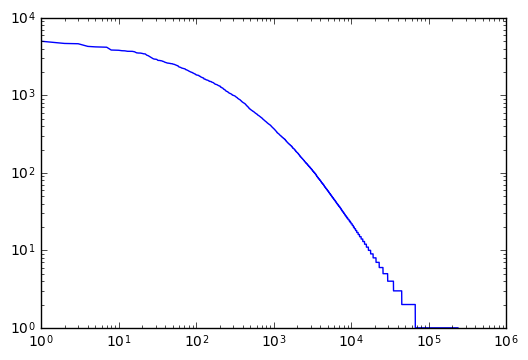

3345


In [10]:
#from math import log
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    d = {}
    for i in X:
        for j in i.indices:
            if d.get(j) == None:
                d[j] = 1
            else:
                d[j] += 1
    a = []
    b = np.zeros(X.shape[1])
    for i in d.items():
        a.append(i[1])
        b[i[0]] = i[1]
    print len(a)
    a.sort()
    a.reverse()
    x = []
    y = []
    for i, j in enumerate(a):
        x.append(log(j + 1))
        y.append(log(i + 1))

    pl.figure()

    #pl.scatter(x, y)
    pl.loglog([i + 1 for i in xrange(len(a))], a)
    pl.show()
    #plt.xlabel('Computer Science Doctorates Awarded (US)')
    #plt.ylabel('Total Arcade Revenue (billions)')
    k = 0
    for i in a:
        if i > 100:
            k += 1
    print k
    return b

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [265]:
X1 = X.tocsc()[:, features_counts > 3000].toarray()

In [266]:
len(X1[0])

27

Вариант задания генерируется на основании вашего ника в техносфере.

In [267]:
USER_NAME = "rom.holin"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


Реализуем выбранный алгоритм

In [321]:
class LogisticRegression():
    def __init__(self, X, Y, L):
        self.ETA = []
        self.fit(X, Y, L)
    
    def std(self, a):
        answer = 0
        for i in a:
            answer += i ** 2
        return np.sqrt(answer)
    
    def h1(self, X, ETA):
        #print np.dot(-ETA, X), np.exp(np.dot(-ETA, X)), 1.0 / (1.0 + np.exp(np.dot(-ETA, X)))
        return 1.0 / (1.0 + np.exp(np.dot(-ETA, X)))
    
    def h2(self, X, ETA):
        return 1.0 / (np.exp(np.dot(-ETA, X)) + np.exp(np.dot(ETA, X)) + 2)
    
    def grad(self, X, Y, Lambda, ETA):
        G = np.zeros(len(X[0]))
        q = []
        for i in xrange(len(X)):
            q.append(self.h1(X[i], ETA) - Y[i])
        for j, g0 in enumerate(G):
            for i, x0 in enumerate(X):
                G[j] += q[i] * X[i][j]
            G[j] /= len(X[0])
            #G[j] += 2 * Lambda * ETA[j]
            #print G[j]
        return G
    
    def hessian(self, X, Y, ETA):
        H = np.zeros((len(X[0]), len(X[0])))
        q = []
        for i in xrange(len(X)):
            q.append(self.h2(X[i], ETA))
            #print "HES", self.h(X[i], ETA), np.exp(np.dot(-ETA, X[i]))
        for k, h0 in enumerate(H):
            for j, h1 in enumerate(H[0]):
                if (j >= k):
                    for i, x0 in enumerate(X):
                        H[k][j] += q[i] * X[i][k] * X[i][j]
                    H[k][j] /= len(X[0])
                else:
                    H[k][j] = H[j][k]
            if k % 10 == 0:
                print "urrraaa ", k
                
        return H
                 
    def fit(self, X, Y, Lambda):
        eps = 0.0001
        ETA0 = np.zeros(len(X[0]))
        ETA = np.array([5.0 for i in xrange(len(X[0]))])#np.ones(len(X[0]))
        cnt = 0
        l = 0.01
        q = 0.9
        while self.std(ETA - ETA0) > eps:
            G = self.grad(X, Y, Lambda, ETA)
            #H = self.hessian(X, Y, ETA)
            #D = np.linalg.solve(H, -G)
            ETA0 = ETA.copy()
            ETA -= l * q
            l *= q
            #print self.std(ETA - ETA0)
        self.ETA = ETA
    
    def predict_proba(self, X):
        answer = []
        for i in X:
            answer.append(self.h1(self.ETA,  i))
        return answer

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [338]:
def auroc(y_prob, y_true):
    y = pd.DataFrame(y_prob, columns=["prob"])
    y["true"] = y_true
    y = y.sort_values(["prob"])
    m0 = 0.0
    m1 = 0.0
    for i in xrange(len(y)):
        if y["true"][i] == 0:
            m0 += 1
        else:
            m1 += 1
    fpr = []
    fpr.append(0.0)
    tpr = []
    tpr.append(0.0)
    auc = 0.0
    for i in xrange(len(y)):
        if y["true"][i] == 0:
            fpr.append(fpr[i] + 1.0/m0)
            tpr.append(tpr[i])            
            auc += (1.0/m0) * tpr[i + 1]
        else:
            fpr.append(fpr[i])
            tpr.append(tpr[i] + 1.0/m1)
    return tpr, fpr, auc

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [328]:
C = []
h = len(X1) / 2 + 1
a = 0
b = h
for i in xrange(2):
    X_train = np.concatenate((X1[0:a], X1[b:]))
    X_test = X1[a:b]
    Y_train = np.concatenate((Y[0:a], Y[b:]))
    Y_test = Y[a:b]
    Y_proba = LogisticRegression(X_train, Y_train, i + 1).predict_proba(X_test)
    C.append(auroc(Y_proba, Y_test)[2])
    a += h
    b += h
print C

def select_reg_parameter(C, X, Y):
    return C.index(max(C))

index = select_reg_parameter(C, X1, Y)
print index


[0.4896441737533713, 0.5068629925337675]
1


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

Area under the ROC curve : 0.485146


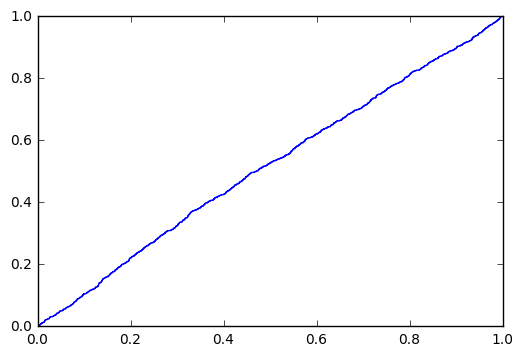

In [341]:
def classify(X1, X2, Y, C):
    model = LogisticRegression(X1, Y, C)
    Y_proba1 = model.predict_proba(X1)
    Y_proba2 = model.predict_proba(X2)
    tpr, fpr, roc_auc = auroc(Y_proba1, Y)
    
    return tpr, fpr, roc_auc, Y_proba2
X_ex1 = X_ex.tocsc()[:, features_counts > 3000].toarray()
tpr, fpr, roc_auc, Y_answer = classify(X1, X_ex1, Y, C[index])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    pl.figure()
    pl.plot(tpr, fpr)
    pl.show()
    # Your code here
    
    return

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.

In [352]:
answer = [0.0 for i in xrange(len(df_users_ex))]
for i, j in enumerate(Y_answer):
    answer[i] = j
df_users_ex["cls"] = answer
df_users_ex.to_csv("answer.csv")